In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.layers import Dense, LSTM
from keras.models import Sequential
import numpy as np

Using TensorFlow backend.


In [2]:
def parser(x):
    return pd.datetime.strptime('190'+x, '%Y-%m')

Dataset = pd.read_csv('/home/hrituraj/Desktop/IOP/sales-of-shampoo-over-a-three-ye.csv',skipfooter = 2,index_col = 0, engine = 'python', parse_dates = [0], date_parser = parser )

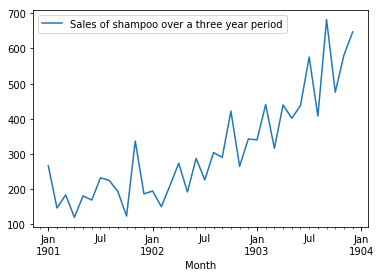

In [3]:
plt.close('all')
Dataset.plot()
plt.show()



In [4]:
X = Dataset.values
train, test = X[0:-12], X[-12:]

Root Mean Squared Error : 136.761318849


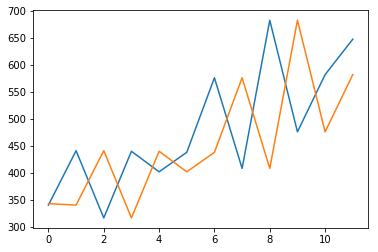

In [5]:
def baseline_model(train, test):
    history = [x for x in train]
    predictions = []
    
    for i in xrange(len(test)):
        #make predictions = last output
        predictions.append(history[-1])
        
        #update history
        history.append(test[i])
        
    return predictions


predictions = baseline_model(train, test)
rmse = sqrt(mean_squared_error(test, predictions))

print "Root Mean Squared Error : {}".format(rmse)

plt.plot(test)
plt.plot(predictions)
plt.show()       

In [6]:
def timeseries_to_supervised(data, lag=1):
    df = pd.DataFrame(data)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = pd.concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

In [7]:
df = timeseries_to_supervised(X)
df

,0,0
0,0.0,266.0
1,266.0,145.9
2,145.9,183.1
3,183.1,119.3
4,119.3,180.3
5,180.3,168.5
6,168.5,231.8
7,231.8,224.5
8,224.5,192.8
9,192.8,122.9


In [8]:
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)


In [9]:
diff = difference(X)
diff.head()

0    [-120.1]
1      [37.2]
2     [-63.8]
3      [61.0]
4     [-11.8]
dtype: object

In [10]:
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

In [11]:
inverted = list()
for i in range(len(diff)):
    value = inverse_difference(X, diff[i], len(Dataset)-i)
    inverted.append(value)
inverted = pd.Series(inverted)
print(inverted.head())

0    [145.9]
1    [183.1]
2    [119.3]
3    [180.3]
4    [168.5]
dtype: object


In [12]:
from sklearn.preprocessing import MinMaxScaler
X = X.reshape(len(X), 1)
scaler = MinMaxScaler(feature_range=(-1, 1))
scaler = scaler.fit(X)
scaled_X = scaler.transform(X)

In [13]:

inverted_X = scaler.inverse_transform(scaled_X)

In [14]:
X, y = train[:, 0:-1], train[:, -1]
X = X.reshape(X.shape[0], 1, X.shape[1])

In [15]:
def scale(train, test):
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled

In [16]:
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss = 'mean_squared_error', optimizer = 'adam')
    
    for i in range(nb_epoch):
        model.fit(X, y, epochs = 1, batch_size = batch_size,verbose = 0, shuffle = False)
        model.reset_states()
    
    return model

        

In [17]:
def forecast_LSTM(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    
    return yhat[0,0]

In [18]:
series = pd.read_csv('/home/hrituraj/Desktop/IOP/sales-of-shampoo-over-a-three-ye.csv', skipfooter = 2,  parse_dates=[0], index_col=0,engine= 'python', date_parser=parser)
series

,Sales of shampoo over a three year period
Month,
1901-01-01,266.0
1901-02-01,145.9
1901-03-01,183.1
1901-04-01,119.3
1901-05-01,180.3
1901-06-01,168.5
1901-07-01,231.8
1901-08-01,224.5
1901-09-01,192.8


In [19]:
raw_values = series.values
diff_values = difference(raw_values, 1)

In [20]:
supervised = timeseries_to_supervised(diff_values, 1)
supervised_values = supervised.values

In [21]:
train, test = supervised_values[0:-12], supervised_values[-12:]

In [22]:
scaler, train_scaled, test_scaled = scale(train, test)

/home/hrituraj/anaconda2/envs/py2/lib/python2.7/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [23]:
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

In [31]:
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)

Month=1, Predicted=323.743745, Expected=339.700000
Month=2, Predicted=410.790261, Expected=440.400000
Month=3, Predicted=368.804731, Expected=315.900000
Month=4, Predicted=438.749171, Expected=439.300000
Month=5, Predicted=353.565184, Expected=401.300000
Month=6, Predicted=499.919613, Expected=437.400000
Month=7, Predicted=470.569814, Expected=575.500000
Month=8, Predicted=455.411279, Expected=407.600000
Month=9, Predicted=526.558572, Expected=682.000000
Month=10, Predicted=374.782353, Expected=475.300000
Month=11, Predicted=488.997388, Expected=581.300000
Month=12, Predicted=357.396199, Expected=646.900000
Test RMSE: 111.808


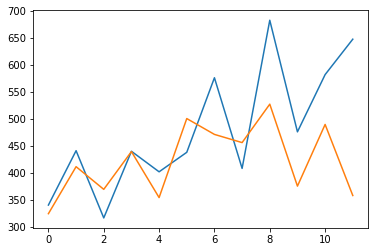

In [32]:
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)
predictions = list()
for i in range(len(test_scaled)):
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_LSTM(lstm_model, 1, X)
    yhat = invert_scale(scaler, X, yhat)
    yhat = inverse_difference(raw_values, yhat, len(test_scaled)+1-i)
    predictions.append(yhat)
    expected = raw_values[len(train) + i + 1]
    print('Month=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
    

rmse = sqrt(mean_squared_error(raw_values[-12:], predictions))

print('Test RMSE: %.3f' % rmse)
plt.plot(raw_values[-12:])
plt.plot(predictions)
plt.show()




    
    
    


                            
                        